In [210]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
from riotwatcher import RiotWatcher
import requests

api_file = os.path.join('..','..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

# Load data and put it into a TFRecords file
Do this to nicely handle the features that is a numpy array (blue_champs and red_champs)

In [211]:
#get all files in challenger_tier data folder, then sort by date
files = glob.glob(os.path.join('LOL_data','*','V9.10','*.csv'))
#files.sort(key=os.path.getmtime)
print(files)

['LOL_data/challenger_tier/V9.10/saved2019-05-28.csv', 'LOL_data/masters_tier/V9.10/saved2019-05-17.csv']


In [212]:
lol_df = None
for filename in files[-2:]:
    print(filename)
    tier = filename[9:-31]
    if tier=='challenger':
        tier_num=0
    elif tier=='masters':
        tier_num=1
    else:
        raise KeyError
    
    if type(lol_df)==None:
        lol_df = pd.read_csv(filename, usecols=range(1,24))
        lol_df['skill_level'] = tier_num
    else:
        new_df = pd.read_csv(filename,usecols=range(1,24))
        new_df['skill_level'] = tier_num
        lol_df = pd.concat([lol_df, new_df],ignore_index=True)

lol_df = lol_df.reindex(np.random.permutation(lol_df.index))
lol_df.describe()

LOL_data/challenger_tier/V9.10/saved2019-05-28.csv
LOL_data/masters_tier/V9.10/saved2019-05-17.csv


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4,skill_level
count,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,...,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000
mean,0.493564,50667.496270,50894.768367,5.239075,5.249990,0.856535,0.857602,1.333948,1.499933,0.424299,...,127.025784,128.486014,128.615937,128.043627,127.839944,128.491395,128.608868,127.264297,126.917019,0.724167
std,0.499959,15476.016762,15707.437316,3.728810,3.767128,1.113665,1.109356,1.214319,1.268132,0.613052,...,130.100459,130.826929,131.269630,130.474368,130.717533,130.736454,131.399606,130.096694,129.770730,0.446933
min,0.000000,3313.000000,3345.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,40860.000000,40873.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,0.000000
50%,0.000000,51309.000000,51651.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,1.000000
75%,1.000000,60938.000000,61422.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,145.000000,154.000000,154.000000,154.000000,150.000000,154.000000,154.000000,150.000000,145.000000,1.000000
max,1.000000,136791.000000,133619.000000,15.000000,15.000000,13.000000,12.000000,7.000000,9.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,1.000000


In [213]:
lol_df['skill_level'].unique()

array([1, 0])

In [214]:
champfile=os.path.join('lol_data','version9.10.1_champion.json')
with open(champfile,'r') as fin:
    champdata=json.load(fin)
champ_vocab=[]
for name,data in champdata['data'].items():
    champ_vocab.append(data['key'])
champ_vocab = [int(i) for i in champ_vocab]
print(len(champ_vocab))

144


144


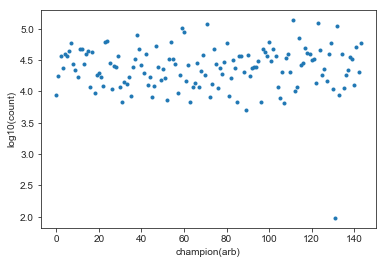

In [215]:
sns.set_style('ticks')
champ_sum = np.concatenate((lol_df['blue_champs0'],lol_df['blue_champs1'],lol_df['blue_champs2'],
            lol_df['blue_champs3'],lol_df['blue_champs4'],lol_df['red_champs0'],
            lol_df['red_champs1'],lol_df['red_champs2'],lol_df['red_champs3'],
            lol_df['red_champs4']),axis=None)

unique, counts= np.unique(champ_sum, return_counts=True)
print(len(unique))
plt.plot(np.log10(counts),'.')
plt.xlabel('champion(arb)')
plt.ylabel('log10(count)')
plt.show()

## Define preprocess functions

In [216]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [217]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords(filename, examples, target_df,target_name):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(filename)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    target_array = np.array(target_df[target_name])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i].tostring()
        red_champs = red_hero_array[:][i].tostring()
        target = target_array[i]

        # Create a feature
        if target_name=='blue_win':
            feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'targets': _int64_feature(target)}
        else:
            feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'targets': _float_feature(target)}
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [218]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords_dota2_compat(filename, examples, target_df,target_name):
    # open the TFRecords file
    options = tf.io.TFRecordOptions('GZIP')
    writer = tf.io.TFRecordWriter(filename,options=options)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    skill_level_array = np.array(examples['skill_level'])
    target_array = np.array(target_df[target_name])

    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i]
        red_champs = red_hero_array[:][i]
        
        blue_champs_index=[]
        red_champs_index=[]
        pass_outer=False
        counter=0
        for red_champ,blue_champ in zip(red_champs,blue_champs):
            #add heroes to the heroes by index list for this game
            try:
                red_champs_index.append(champ_vocab.index(red_champ))
                blue_champs_index.append(champ_vocab.index(blue_champ))
            #if the hero isnt in the vocab then break and pass so 
            #  the example isnt used for training
            except ValueError:
                counter+=1
                pass_outer = True
                break
        if pass_outer:
            pass_outer=False
            continue
            

        skill_level = skill_level_array[i]
        #convert skill_level to one_hot
        skill_level = tf.keras.utils.to_categorical(skill_level,
                                                    num_classes=2,
                                                    dtype='int64')

        target = target_array[i]
        
        # Create a feature
        if target_name=='blue_win':
            feature = {'radiant_heroes': _int64_list_feature(blue_champs_index),
                   'dire_heroes': _int64_list_feature(red_champs_index),
                   'skill_level': _int64_list_feature(skill_level),
                   'targets': _int64_feature(target)}
        else:
            feature = {'blue_champs': _int64_list_feature(blue_champs_index),
                   'red_champs': _int64_list_feature(red_champs_index),
                   'skill_level': _int64_list_feature(skill_level),
                   'targets': _float_feature(target)}
        
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [219]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords_dual(filename, examples, target_df):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(filename)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    win_array = np.array(target_df['blue_win'])
    gold_diff_array = np.array(target_df['gold_diff'])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i].tostring()
        red_champs = red_hero_array[:][i].tostring()
        blue_win = win_array[i]
        gold_diff = gold_diff_array[i]
        
        # Create a feature
        feature = {'blue_champs': _bytes_feature(tf.compat.as_bytes(blue_champs)),
                   'red_champs': _bytes_feature(tf.compat.as_bytes(red_champs)),
                   'blue_win': _int64_feature(blue_win),
                   'gold_diff': _float_feature(gold_diff)}

        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [220]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords_dual_dota2_compat(filename, examples, target_df):
    # open the TFRecords file
    options = tf.io.TFRecordOptions('GZIP')
    writer = tf.io.TFRecordWriter(filename,options=options)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    skill_level_array = np.array(examples['skill_level'])

    win_array = np.array(target_df['blue_win'])
    gold_diff_array = np.array(target_df['gold_diff'])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i]
        red_champs = red_hero_array[:][i]
        blue_win = win_array[i]
        gold_diff = gold_diff_array[i]
        skill_level = skill_level_array[i]

        #convert skill_level to one_hot
        skill_level = tf.keras.utils.to_categorical(skill_level,
                                                    num_classes=2,
                                                    dtype='int64')        
        blue_champs_index=[]
        red_champs_index=[]
        pass_outer=False
        counter=0
        for red_champ,blue_champ in zip(red_champs,blue_champs):
            #add heroes to the heroes by index list for this game
            try:
                red_champs_index.append(champ_vocab.index(red_champ))
                blue_champs_index.append(champ_vocab.index(blue_champ))
            #if the hero isnt in the vocab then break and pass so 
            #  the example isnt used for training
            except ValueError:
                counter+=1
                pass_outer = True
                break
        if pass_outer:
            pass_outer=False
            continue

        # Create a feature
        feature = {'radiant_heroes': _int64_list_feature(blue_champs_index),
                   'dire_heroes': _int64_list_feature(red_champs_index),
                   'skill_level': _int64_list_feature(skill_level),
                   'radiant_win': _int64_feature(blue_win),
                   'gold_diff': _float_feature(gold_diff)}

        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [221]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords_triple_dota2_compat(filename, examples, target_df):
    # open the TFRecords file
    options = tf.io.TFRecordOptions('GZIP')
    writer = tf.io.TFRecordWriter(filename,options=options)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    skill_array = np.array(examples['skill_level'])
    win_array = np.array(target_df['blue_win'])
    gold_diff_array = np.array(target_df['gold_diff'])
    total_gold_array = np.array(target_df['total_gold'])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i]
        red_champs = red_hero_array[:][i]
        blue_win = win_array[i]
        gold_diff = gold_diff_array[i]
        total_gold = total_gold_array[i]
        
        skill_level = skill_array[i]
        #convert skill_level to one_hot
        
        skill_level = tf.keras.utils.to_categorical(skill_level,
                                                    num_classes=2,
                                                    dtype='int64')        
        counter=0
        blue_champs_index=[]
        red_champs_index=[]
        pass_outer=False
        for red_champ,blue_champ in zip(red_champs,blue_champs):
            #add heroes to the heroes by index list for this game
            try:
                red_champs_index.append(champ_vocab.index(red_champ))
                blue_champs_index.append(champ_vocab.index(blue_champ))
            #if the hero isnt in the vocab then break and pass so 
            #  the example isnt used for training
            except ValueError:
                counter+=1
                pass_outer = True
                break
        if pass_outer:
            pass_outer=False
            continue

        # Create a feature
        feature = {'radiant_heroes': _int64_list_feature(blue_champs_index),
                   'dire_heroes': _int64_list_feature(red_champs_index),
                   'skill_level': _int64_list_feature(skill_level),
                   'radiant_win': _int64_feature(blue_win),
                   'gold_diff': _float_feature(gold_diff),
                   'total_gold': _float_feature(total_gold)}

        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    print('Out of vocab:',counter)
    writer.close()
    sys.stdout.flush()

In [222]:
#target_name to name tfrecords file and the target_df column to call
#for now don't keep all possible targets in target_df
#target_df selection is made with the preprocess_target function call
def convert_to_tfrecords_penta_dota2_compat(filename, examples, target_df):
    # open the TFRecords file
    options = tf.io.TFRecordOptions('GZIP')
    writer = tf.io.TFRecordWriter(filename,options=options)
    
    blue_hero_array = np.array(examples['blue_champs'])
    red_hero_array = np.array(examples['red_champs'])
    skill_array = np.array(examples['skill_level'])
    win_array = np.array(target_df['blue_win'])
    gold_diff_array = np.array(target_df['gold_diff'])
    total_gold_array = np.array(target_df['total_gold'])
    towkill_diff_array = np.array(target_df['towkill_diff'])
    towkill_total_array = np.array(target_df['towkill_total'])
    
    for i in range(len(blue_hero_array[:])):
        # print how many games are saved every 10000 games
        if not i % 10000:
            print('Train data: %d/%d' % (i, len(examples)))
            sys.stdout.flush()
            
        # Load the hero_array
        blue_champs = blue_hero_array[:][i]
        red_champs = red_hero_array[:][i]
        blue_win = win_array[i]
        gold_diff = gold_diff_array[i]
        total_gold = total_gold_array[i]
        towkill_diff = towkill_diff_array[i]
        towkill_total = towkill_total_array[i]
        
        skill_level = skill_array[i]
        #convert skill_level to one_hot
        skill_level = tf.keras.utils.to_categorical(skill_level,
                                                    num_classes=2,
                                                    dtype='int64')        
        blue_champs_index=[]
        red_champs_index=[]
        pass_outer=False
        counter=0
        for j in range(5):
            #add heroes to the heroes by index list for this game
            try:
                red_champs_index.append(champ_vocab.index(red_champs[j]))
                blue_champs_index.append(champ_vocab.index(blue_champs[j]))
            #if the hero isnt in the vocab then break and pass so 
            #  the example isnt used for training
            except ValueError:
                counter+=1
                pass_outer = True
                break
        if pass_outer:
            pass_outer=False
            continue

        # Create a feature
        feature = {'radiant_heroes': _int64_list_feature(blue_champs_index),
                   'dire_heroes': _int64_list_feature(red_champs_index),
                   'skill_level': _int64_list_feature(skill_level),
                   'radiant_win': _int64_feature(blue_win),
                   'gold_diff': _float_feature(gold_diff),
                   'total_gold': _float_feature(total_gold),
                   'tower_damage_diff': _float_feature(towkill_diff),
                   'total_tower_damage': _float_feature(towkill_total)}

        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [223]:
def z_score(column):
    return (column-column.mean())/column.std()

def preprocess_features(lol_df):
    """Take lol_df and create a dataframe containing only the features for our model
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                processed_df: pandas DataFrame containing only feature columns
    """
    
    #Use arrays of champs for each team as features rather than each hero
    #individually to help model fit?
    #This is an attempt to make the model more similar to the movie review
    #text analysis example in the Google ML Crash Course
    processed_df = pd.DataFrame()
    
    processed_df['blue_champs'] = list(np.array(lol_df.loc[:,['blue_champs0',
                                                'blue_champs1','blue_champs2',
                                                'blue_champs3','blue_champs4']]).astype(int))
    processed_df['red_champs'] = list(np.array(lol_df.loc[:,['red_champs0',
                                    'red_champs1','red_champs2',
                                    'red_champs3','red_champs4']]).astype(int))
    processed_df['skill_level'] = list(np.array(lol_df['skill_level']).astype(int))
    
    return processed_df
    
def preprocess_targets_win(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model. (blue_win here)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column
    """
    target_df = pd.DataFrame()
    target_df['blue_win'] = lol_df['blue_win']
    
    return target_df

def preprocess_targets_gold(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized gold difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (gold_diff)
    """
    target_df = pd.DataFrame()
    target_df['gold_diff'] = zscore(lol_df['blue_gold']-lol_df['red_gold'])
    return target_df

def preprocess_targets_dual_gold_win(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized gold difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (gold_diff)
    """
    target_df = pd.DataFrame()
    target_df['blue_win'] = lol_df['blue_win']
    target_df['gold_diff'] = lol_df['blue_gold']-lol_df['red_gold']
    target_df['gold_diff'] = z_score(target_df['gold_diff'])
    
    return target_df

def preprocess_targets_triple_gold_win(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized gold difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (gold_diff)
    """
    target_df = pd.DataFrame()
    target_df['blue_win'] = lol_df['blue_win']
    target_df['gold_diff'] = lol_df['blue_gold']-lol_df['red_gold']
    target_df['gold_diff'] = z_score(target_df['gold_diff'])
    target_df['total_gold'] = lol_df['blue_gold']+lol_df['red_gold']
    target_df['total_gold'] = z_score(target_df['total_gold'])

    return target_df

def preprocess_targets_penta_gold_win_tow(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized gold difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (gold_diff)
    """
    target_df = pd.DataFrame()
    target_df['blue_win'] = lol_df['blue_win']
    target_df['gold_diff'] = lol_df['blue_gold']-lol_df['red_gold']
    target_df['gold_diff'] = z_score(target_df['gold_diff'])
    target_df['total_gold'] = lol_df['blue_gold']+lol_df['red_gold']
    target_df['total_gold'] = z_score(target_df['total_gold'])
    target_df['towkill_diff'] = lol_df['blue_tower_kills']-lol_df['red_tower_kills']
    target_df['towkill_diff'] = z_score(target_df['towkill_diff'].astype('float32'))
    target_df['towkill_total'] = lol_df['blue_tower_kills']-lol_df['red_tower_kills']
    target_df['towkill_total'] = z_score(target_df['towkill_total'].astype('float32'))

    return target_df

#this can be easily modified for baron, dragon, or inhib kills
def preprocess_targets_towerkills(lol_df):
    """Take lol_df and create a dataframe containing only the targets for our model 
        (normalized tower_kill difference in this case)
            Args: 
                lol_df: Dataframe containing lol training and test data
            returns: 
                target_df: pandas DataFrame containing only the target column (tower_kills)
    """

    target_df = pd.DataFrame()
    target_df['towkill_diff'] = z_score(lol_df['blue_tower_kills']\
                                        -lol_df['red_tower_kills'])
    return target_df

### Visualize data for each set

In [224]:
plotting_df = lol_df

display.display(plotting_df.iloc[:train_len,:].describe())
display.display(plotting_df.iloc[train_len:train_len+test_len,:].describe())
display.display(plotting_df.iloc[train_len+test_len:,:].describe())

,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4,skill_level
count,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,...,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000,309173.000000
mean,0.493180,50677.244856,50908.076734,5.238132,5.254670,0.856207,0.858798,1.333884,1.500723,0.423782,...,127.179524,128.475905,128.596831,128.259026,127.706090,128.429831,128.585805,127.339991,126.770915,0.724843
std,0.499954,15478.656316,15705.939751,3.729405,3.766369,1.113072,1.109509,1.214180,1.268674,0.612303,...,130.329952,130.813739,131.241006,130.725584,130.717611,130.753230,131.460665,130.109492,129.502366,0.446594
min,0.000000,3313.000000,3450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,40858.000000,40880.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,0.000000
50%,0.000000,51314.000000,51657.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,84.000000,1.000000
75%,1.000000,60958.000000,61427.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,145.000000,154.000000,154.000000,154.000000,150.000000,154.000000,154.000000,150.000000,145.000000,1.000000
max,1.000000,123647.000000,131532.000000,11.000000,15.000000,13.000000,12.000000,7.000000,7.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,1.000000


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4,skill_level
count,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,...,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000,44168.000000
mean,0.497917,50669.644720,50839.644765,5.266845,5.229646,0.863136,0.855416,1.336895,1.491147,0.429315,...,126.806240,128.587643,128.103174,126.428817,128.161972,128.938553,128.264943,127.164146,127.665663,0.725231
std,0.500001,15541.908527,15752.838194,3.734580,3.769924,1.119480,1.113935,1.218466,1.262899,0.618529,...,129.280443,131.022584,130.565127,129.371614,130.313431,130.675242,130.681972,130.550091,130.722591,0.446403
min,0.000000,3618.000000,3381.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,40848.000000,40797.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,0.000000
50%,0.000000,51296.000000,51662.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,85.000000,85.000000,85.000000,84.000000,85.000000,85.000000,85.000000,84.000000,85.000000,1.000000
75%,1.000000,60951.000000,61375.250000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,145.000000,150.000000,154.000000,145.000000,157.000000,157.000000,154.000000,150.000000,150.000000,1.000000
max,1.000000,123224.000000,120711.000000,15.000000,11.000000,13.000000,10.000000,7.000000,7.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,1.000000


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4,skill_level
count,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.00000,88336.000000,88336.000000,88336.000000,...,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000,88336.000000
mean,0.492732,50632.302323,50875.751336,5.228491,5.243785,0.854386,0.85451,1.332696,1.501562,0.423599,...,126.597469,128.470578,128.939187,128.097140,128.147414,128.483291,128.861551,127.049448,127.054055,0.721269
std,0.499950,15433.828759,15690.034115,3.723810,3.768385,1.112824,1.10653,1.212739,1.268842,0.612915,...,129.704994,130.776645,131.720909,130.138724,130.919521,130.709374,131.544616,129.825723,130.230575,0.448378
min,0.000000,3322.000000,3345.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,40873.000000,40873.750000,2.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,0.000000
50%,0.000000,51302.000000,51625.500000,5.000000,5.000000,0.000000,0.00000,1.000000,1.000000,0.000000,...,84.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,84.000000,84.000000,1.000000
75%,1.000000,60861.250000,61425.000000,9.000000,9.000000,1.000000,1.00000,2.000000,2.000000,1.000000,...,145.000000,154.000000,157.000000,154.000000,154.000000,154.000000,157.000000,150.000000,145.000000,1.000000
max,1.000000,136791.000000,133619.000000,11.000000,12.000000,10.000000,12.00000,7.000000,9.000000,4.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,1.000000


### Export win tfrecord

In [115]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

target_name='blue_win'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])

if target_name=='blue_win':
    train_targets = preprocess_targets_win(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_win(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_win(lol_df.iloc[train_len+test_len:,:])
else:
    train_targets = preprocess_targets_gold(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_gold(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_gold(lol_df.iloc[train_len+test_len:,:])



convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/309173
Train data: 10000/309173
Train data: 20000/309173
Train data: 30000/309173
Train data: 40000/309173
Train data: 50000/309173
Train data: 60000/309173
Train data: 70000/309173
Train data: 80000/309173
Train data: 90000/309173
Train data: 100000/309173
Train data: 110000/309173
Train data: 120000/309173
Train data: 130000/309173
Train data: 140000/309173
Train data: 150000/309173
Train data: 160000/309173
Train data: 170000/309173
Train data: 180000/309173
Train data: 190000/309173
Train data: 200000/309173
Train data: 210000/309173
Train data: 220000/309173
Train data: 230000/309173
Train data: 240000/309173
Train data: 250000/309173
Train data: 260000/309173
Train data: 270000/309173
Train data: 280000/309173
Train data: 290000/309173
Train data: 300000/309173
Train data: 0/88336
Train data: 10000/88336
Train data: 20000/88336
Train data: 30000/88336
Train data: 40000/88336
Train data: 50000/88336
Train data: 60000/88336
Train data: 70000/88336
Train data: 80000/88

### Export win dota2 compat tfrecord

In [202]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

target_name='blue_win'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])

if target_name=='blue_win':
    train_targets = preprocess_targets_win(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_win(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_win(lol_df.iloc[train_len+test_len:,:])
else:
    train_targets = preprocess_targets_gold(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_gold(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_gold(lol_df.iloc[train_len+test_len:,:])

convert_to_tfrecords_dota2_compat(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_dota2_compat_lol_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords_dota2_compat(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_dota2_compat_lol_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords_dota2_compat(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_dota2_compat_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/309173
Train data: 10000/309173
Train data: 20000/309173
Train data: 30000/309173
Train data: 40000/309173
Train data: 50000/309173
Train data: 60000/309173
Train data: 70000/309173
Train data: 80000/309173
Train data: 90000/309173
Train data: 100000/309173
Train data: 110000/309173
Train data: 120000/309173
Train data: 130000/309173
Train data: 140000/309173
Train data: 150000/309173
Train data: 160000/309173
Train data: 170000/309173
Train data: 180000/309173
Train data: 190000/309173
Train data: 200000/309173
Train data: 210000/309173
Train data: 220000/309173
Train data: 230000/309173
Train data: 240000/309173
Train data: 250000/309173
Train data: 260000/309173
Train data: 270000/309173
Train data: 280000/309173
Train data: 290000/309173
Train data: 300000/309173
Train data: 0/88336
Train data: 10000/88336
Train data: 20000/88336
Train data: 30000/88336
Train data: 40000/88336
Train data: 50000/88336
Train data: 60000/88336
Train data: 70000/88336
Train data: 80000/88

### Export gold tfrecord

In [13]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
test_len = int((len(lol_df) - train_len)/1.5)
validation_len = len(lol_df) - train_len - test_len

target_name='gold_diff'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])

if target_name=='blue_win':
    train_targets = preprocess_targets_win(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_win(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_win(lol_df.iloc[train_len+test_len:,:])
else:
    train_targets = preprocess_targets_gold(lol_df.iloc[:train_len,:])
    test_targets = preprocess_targets_gold(lol_df.iloc[train_len:train_len+test_len,:])
    validation_targets = preprocess_targets_gold(lol_df.iloc[train_len+test_len:,:])

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets,
                     target_name=target_name)

convert_to_tfrecords(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets,
                     target_name=target_name)


Train data: 0/309173
Train data: 10000/309173
Train data: 20000/309173
Train data: 30000/309173
Train data: 40000/309173
Train data: 50000/309173
Train data: 60000/309173
Train data: 70000/309173
Train data: 80000/309173
Train data: 90000/309173
Train data: 100000/309173
Train data: 110000/309173
Train data: 120000/309173
Train data: 130000/309173
Train data: 140000/309173
Train data: 150000/309173
Train data: 160000/309173
Train data: 170000/309173
Train data: 180000/309173
Train data: 190000/309173
Train data: 200000/309173
Train data: 210000/309173
Train data: 220000/309173
Train data: 230000/309173
Train data: 240000/309173
Train data: 250000/309173
Train data: 260000/309173
Train data: 270000/309173
Train data: 280000/309173
Train data: 290000/309173
Train data: 300000/309173
Train data: 0/88336
Train data: 10000/88336
Train data: 20000/88336
Train data: 30000/88336
Train data: 40000/88336
Train data: 50000/88336
Train data: 60000/88336
Train data: 70000/88336
Train data: 80000/88

### Export dual gold_win tfrecord

In [104]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
validation_len = int((len(lol_df) - train_len)/1.5)
test_len = len(lol_df) - train_len - validation_len

target_name='dual_gold_win'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])


train_targets = preprocess_targets_dual_gold_win(lol_df.iloc[:train_len,:])
test_targets = preprocess_targets_dual_gold_win(lol_df.iloc[train_len:train_len+test_len,:])
validation_targets = preprocess_targets_dual_gold_win(lol_df.iloc[train_len+test_len:,:])

convert_to_tfrecords_dual(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets)
convert_to_tfrecords_dual(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets)

convert_to_tfrecords_dual(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets)

NameError: name 'convert_to_tfrecords_dual' is not defined

### Export dual model with dota compatibility for easy keras model reusing

In [203]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
validation_len = int((len(lol_df) - train_len)/1.5)
test_len = len(lol_df) - train_len - validation_len

target_name='dual_gold_win_dota2_compat'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])

train_targets = preprocess_targets_dual_gold_win(lol_df.iloc[:train_len,:])
test_targets = preprocess_targets_dual_gold_win(lol_df.iloc[train_len:train_len+test_len,:])
validation_targets = preprocess_targets_dual_gold_win(lol_df.iloc[train_len+test_len:,:])

convert_to_tfrecords_dual_dota2_compat(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets)
convert_to_tfrecords_dual_dota2_compat(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets)

convert_to_tfrecords_dual_dota2_compat(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets)

Train data: 0/309173
Train data: 10000/309173
Train data: 20000/309173
Train data: 30000/309173
Train data: 40000/309173
Train data: 50000/309173
Train data: 60000/309173
Train data: 70000/309173
Train data: 80000/309173
Train data: 90000/309173
Train data: 100000/309173
Train data: 110000/309173
Train data: 120000/309173
Train data: 130000/309173
Train data: 140000/309173
Train data: 150000/309173
Train data: 160000/309173
Train data: 170000/309173
Train data: 180000/309173
Train data: 190000/309173
Train data: 200000/309173
Train data: 210000/309173
Train data: 220000/309173
Train data: 230000/309173
Train data: 240000/309173
Train data: 250000/309173
Train data: 260000/309173
Train data: 270000/309173
Train data: 280000/309173
Train data: 290000/309173
Train data: 300000/309173
Train data: 0/44168
Train data: 10000/44168
Train data: 20000/44168
Train data: 30000/44168
Train data: 40000/44168
Train data: 0/88336
Train data: 10000/88336
Train data: 20000/88336
Train data: 30000/88336


### Export triple win gold diff and total tfrecord

In [225]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
validation_len = int((len(lol_df) - train_len)/1.5)
test_len = len(lol_df) - train_len - validation_len

target_name='triple_gold_win_dota2_compat'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])


train_targets = preprocess_targets_triple_gold_win(lol_df.iloc[:train_len,:])
test_targets = preprocess_targets_triple_gold_win(lol_df.iloc[train_len:train_len+test_len,:])
validation_targets = preprocess_targets_triple_gold_win(lol_df.iloc[train_len+test_len:,:])

convert_to_tfrecords_triple_dota2_compat(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets)
convert_to_tfrecords_triple_dota2_compat(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets)

convert_to_tfrecords_triple_dota2_compat(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets)

Train data: 0/309173
Train data: 10000/309173
Train data: 20000/309173
Train data: 30000/309173
Train data: 40000/309173
Train data: 50000/309173
Train data: 60000/309173
Train data: 70000/309173
Train data: 80000/309173
Train data: 90000/309173
Train data: 100000/309173
Train data: 110000/309173
Train data: 120000/309173
Train data: 130000/309173
Train data: 140000/309173
Train data: 150000/309173
Train data: 160000/309173
Train data: 170000/309173
Train data: 180000/309173
Train data: 190000/309173
Train data: 200000/309173
Train data: 210000/309173
Train data: 220000/309173
Train data: 230000/309173
Train data: 240000/309173
Train data: 250000/309173
Train data: 260000/309173
Train data: 270000/309173
Train data: 280000/309173
Train data: 290000/309173
Train data: 300000/309173
Out of vocab: 0
Train data: 0/44168
Train data: 10000/44168
Train data: 20000/44168
Train data: 30000/44168
Train data: 40000/44168
Out of vocab: 0
Train data: 0/88336
Train data: 10000/88336
Train data: 2000

### Export penta target tfrecord dota compat gold, tower (diff and total) and win

In [209]:
tier = 'mix_tier'
training_frac = 0.7
train_len = int(len(lol_df) * training_frac)
validation_len = int((len(lol_df) - train_len)/1.5)
test_len = len(lol_df) - train_len - validation_len

target_name='penta_gold_win_dota2_compat'
train_features = preprocess_features(lol_df.iloc[:train_len,:])
test_features = preprocess_features(lol_df.iloc[train_len:train_len+test_len,:])
validation_features = preprocess_features(lol_df.iloc[train_len+test_len:,:])


train_targets = preprocess_targets_penta_gold_win_tow(lol_df.iloc[:train_len,:])
test_targets = preprocess_targets_penta_gold_win_tow(lol_df.iloc[train_len:train_len+test_len,:])
validation_targets = preprocess_targets_penta_gold_win_tow(lol_df.iloc[train_len+test_len:,:])

convert_to_tfrecords_penta_dota2_compat(os.path.join('LOL_data',tier,'lol_training_data', 
                     target_name+'_lol_training_data.tfrecords'),
                     train_features,
                     train_targets)

convert_to_tfrecords_penta_dota2_compat(os.path.join('LOL_data',tier,'lol_test_data', 
                     target_name+'_lol_test_data.tfrecords'),
                     test_features,
                     test_targets)

convert_to_tfrecords_penta_dota2_compat(os.path.join('LOL_data',tier,'lol_validation_data',
                     target_name+'_lol_validation_data.tfrecords'),
                     validation_features,
                     validation_targets)

Train data: 0/309173
Train data: 10000/309173
Train data: 20000/309173
Train data: 30000/309173
Train data: 40000/309173
Train data: 50000/309173
Train data: 60000/309173
Train data: 70000/309173
Train data: 80000/309173
Train data: 90000/309173
Train data: 100000/309173
Train data: 110000/309173
Train data: 120000/309173
Train data: 130000/309173
Train data: 140000/309173
Train data: 150000/309173
Train data: 160000/309173
Train data: 170000/309173
Train data: 180000/309173
Train data: 190000/309173
Train data: 200000/309173
Train data: 210000/309173
Train data: 220000/309173
Train data: 230000/309173
Train data: 240000/309173
Train data: 250000/309173
Train data: 260000/309173
Train data: 270000/309173
Train data: 280000/309173
Train data: 290000/309173
Train data: 300000/309173
Train data: 0/44168
Train data: 10000/44168
Train data: 20000/44168
Train data: 30000/44168
Train data: 40000/44168
Train data: 0/88336
Train data: 10000/88336
Train data: 20000/88336
Train data: 30000/88336
